# Results Dashboard: MLP Classic, BNN Ensembles, and NUTS Ensembles

This notebook visualizes and compares results from:
- MLP Classic baseline ensemble run (single experiment folder)
- BNN ensemble experiments (multiple experiment folders)
- NUTS ensemble experiments (multiple experiment folders)

It provides quick plots and tables for performance, calibration, and diversity, plus an interactive browser for BNN experiments.

In [1]:
# Setup and Imports
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display  # ensure display is always available

# Optional widgets
try:
    import ipywidgets as widgets
    HAS_WIDGETS = True
except Exception:
    HAS_WIDGETS = False

# Style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)


In [2]:
# Configure Paths (MLP, BNN, NUTS)
ROOT = Path(r"c:\Users\roeym\Desktop\projects\theses\first_steps_ensemble")
MLP_RUN = ROOT / r"results/ensemble_mlp_classic/mlp_classic_baseline-20250925-141805"
BNN_ROOT = ROOT / r"results/ensemble_bnn"
NUTS_ROOT = ROOT / r"results/ensemble_nuts"

print("MLP_RUN:", MLP_RUN)
print("BNN_ROOT:", BNN_ROOT)
print("NUTS_ROOT:", NUTS_ROOT)

for p in [MLP_RUN, BNN_ROOT, NUTS_ROOT]:
    print(f"Exists[{p}]:", p.exists())


MLP_RUN: c:\Users\roeym\Desktop\projects\theses\first_steps_ensemble\results\ensemble_mlp_classic\mlp_classic_baseline-20250925-141805
BNN_ROOT: c:\Users\roeym\Desktop\projects\theses\first_steps_ensemble\results\ensemble_bnn
NUTS_ROOT: c:\Users\roeym\Desktop\projects\theses\first_steps_ensemble\results\ensemble_nuts
Exists[c:\Users\roeym\Desktop\projects\theses\first_steps_ensemble\results\ensemble_mlp_classic\mlp_classic_baseline-20250925-141805]: False
Exists[c:\Users\roeym\Desktop\projects\theses\first_steps_ensemble\results\ensemble_bnn]: True
Exists[c:\Users\roeym\Desktop\projects\theses\first_steps_ensemble\results\ensemble_nuts]: True


# Baseline results — Radar chart for MLP and Logistic Regression

We load the baseline metrics CSV (written by `scripts/run_baseline.py`) and plot a radar chart on the test split for both models. Metrics used: accuracy, precision, recall, f1, and roc_auc (all on [0,1]).

In [3]:
# Helpers: File Discovery and Safe Loading

def read_csv_safe(path: Path) -> Optional[pd.DataFrame]:
    try:
        if path.exists():
            return pd.read_csv(path)
    except Exception as e:
        print(f"WARN: Failed to read CSV {path}: {e}")
    return None


def read_json_safe(path: Path) -> Optional[dict]:
    try:
        if path.exists():
            with open(path, 'r', encoding='utf-8') as f:
                return json.load(f)
    except Exception as e:
        print(f"WARN: Failed to read JSON {path}: {e}")
    return None


def list_subdirs(path: Path) -> List[Path]:
    return [p for p in path.iterdir() if p.is_dir()]


def find_files(path: Path, pattern: str) -> List[Path]:
    return list(path.rglob(pattern))


## Utility: member correlation heatmap from proba/prediction tables

Both BNN and NUTS experiments save per-member tables:
- member_[val|test]_proba_table.csv (rows = members, cols = samples, values = P(y=1))
- member_[val|test]_predictions.csv (rows = members, cols = samples, values = {0,1})

The simplest common correlation is Pearson correlation across members using these rows.
The helpers below build a symmetric member-by-member matrix and render a heatmap.

In [4]:
# Correlation helpers shared by BNN and NUTS
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def _load_member_matrix(exp_dir: Path, split: str = 'test', kind: str = 'proba') -> pd.DataFrame | None:
    """
    Load member-by-sample matrix for a given experiment directory.
    kind: 'proba' -> member_[split]_proba_table.csv (values in [0,1])
          'pred'  -> member_[split]_predictions.csv (values in {0,1})
    Returns DataFrame with rows=members, cols=samples.
    """
    if kind == 'proba':
        path = exp_dir / f"member_{split}_proba_table.csv"
    else:
        path = exp_dir / f"member_{split}_predictions.csv"
    if not path.exists():
        return None
    try:
        df = pd.read_csv(path, index_col=0)
        # ensure numeric
        df = df.apply(pd.to_numeric, errors='coerce')
        return df
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None


def compute_member_pearson_corr(df: pd.DataFrame) -> np.ndarray:
    """
    Compute Pearson correlation among members based on row vectors.
    df: rows=members, cols=samples
    Returns a square matrix (n_members x n_members).
    """
    X = df.to_numpy()
    # corr among rows → set rowvar=True (each row is a variable/member)
    C = np.corrcoef(X)
    # numerical guards
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
    # clip to [-1,1]
    C = np.clip(C, -1.0, 1.0)
    return C


def plot_member_corr_heatmap(C: np.ndarray, member_names: list[str] | None = None, title: str = 'Member Pearson correlation'):
    n = C.shape[0]
    if member_names is None:
        member_names = [f"member_{i+1:03d}" for i in range(n)]
    plt.figure(figsize=(6,5))
    sns.heatmap(C, vmin=-1, vmax=1, cmap='coolwarm', square=True, cbar_kws={'label': 'Pearson corr'})
    plt.xticks(ticks=np.arange(n)+0.5, labels=member_names, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(n)+0.5, labels=member_names, rotation=0)
    plt.title(title)
    plt.tight_layout(); plt.show()


def render_experiment_member_corr(exp_dir: Path, split_priority=('test','val')):
    """
    Try proba table first (test then val), fallback to predictions.
    exp_dir points to results family experiment directory (e.g., results/ensemble_nuts/<exp>).
    """
    exp_dir = Path(exp_dir)
    chosen = None
    df = None
    for split in split_priority:
        df = _load_member_matrix(exp_dir, split=split, kind='proba')
        if df is not None:
            chosen = (split, 'proba'); break
    if df is None:
        for split in split_priority:
            df = _load_member_matrix(exp_dir, split=split, kind='pred')
            if df is not None:
                chosen = (split, 'pred'); break
    if df is None:
        print(f"No member proba/prediction tables found under {exp_dir}")
        return
    C = compute_member_pearson_corr(df)
    names = list(df.index)
    title = f"Member Pearson correlation ({chosen[1]} | {chosen[0]})"
    plot_member_corr_heatmap(C, names, title)
    return C, names, chosen

### Quick use: render a member correlation heatmap for a selected experiment

Use `render_experiment_member_corr(<exp_dir>)` where `<exp_dir>` is one of:
- results/ensemble_nuts/<experiment>
- results/ensemble_bnn/<experiment>

It will prefer probability tables on the test split, then val, falling back to predictions if needed.

Using metrics file: c:\Users\roeym\Desktop\projects\theses\first_steps_ensemble\results\metrics\baseline_wine_metrics.csv


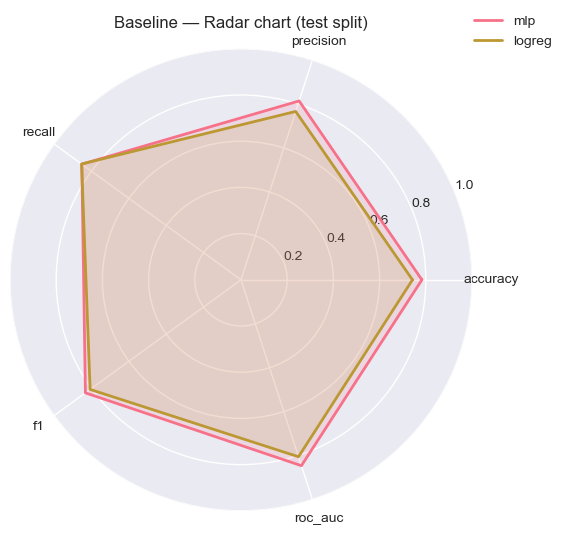

In [5]:
# Load baseline metrics and plot a radar chart for MLP vs Logistic Regression
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Locate baseline metrics CSV written by scripts/run_baseline.py
ROOT = Path(r"c:\\Users\\roeym\\Desktop\\projects\\theses\\first_steps_ensemble")
METRICS_DIR = ROOT / 'results' / 'metrics'
# Try to find the latest baseline metrics csv
candidates = sorted(METRICS_DIR.glob('*_metrics.csv'))
if not candidates:
    print('No baseline metrics CSV found in', METRICS_DIR)
else:
    metrics_csv = candidates[-1]
    print('Using metrics file:', metrics_csv)
    df = pd.read_csv(metrics_csv)
    # Expect index as model names if saved with index; otherwise use a column heuristic
    # The saved file uses index=True, so model names are in the first unnamed column
    if df.columns[0].startswith('Unnamed'):
        df = df.rename(columns={df.columns[0]: 'model'})
    # Filter to test split and select models
    dft = df[df['split'] == 'test'].copy()
    dft = dft.set_index('model') if 'model' in dft.columns else dft
    # Keep only the two baseline models if present
    models = [m for m in ['mlp', 'logreg'] if m in dft.index]
    if not models:
        print('No baseline models found in metrics CSV')
    else:
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        # Build radar values
        values = np.array([dft.loc[m, metrics].values.astype(float) for m in models])
        labels = metrics
        N = len(labels)
        angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
        angles += angles[:1]

        fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(6,6))
        for i, m in enumerate(models):
            vals = values[i].tolist()
            vals += vals[:1]
            ax.plot(angles, vals, label=m, linewidth=2)
            ax.fill(angles, vals, alpha=0.15)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels)
        ax.set_title('Baseline — Radar chart (test split)')
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
        plt.show()

# MLP Classic Baseline: Members vs Ensemble Metrics Plot

A per-metric summary comparing member distributions (boxplots + jittered points) against the ensemble’s test metric (red line). Uses the same Pearson member-correlation heatmap helper for consistency.

# NUTS ensembles — KPIs, bars, and member-correlation heatmap

,accuracy,precision,recall,f1,roc_auc,log_loss,ece
experiment,,,,,,,
aggressive_thinning,0.820769,0.614583,0.231373,0.336182,0.816017,0.388692,0.025047
baseline_wine,0.823077,0.623762,0.247059,0.353933,0.815645,0.388865,0.021442
lean_low_ece,0.820000,0.608247,0.231373,0.335227,0.815243,0.389089,0.027732
linspace_broad_pool,0.823077,0.626263,0.243137,0.350282,0.815825,0.388511,0.022581
per_chain_diverse,0.823846,0.630000,0.247059,0.354930,0.815840,0.388586,0.029434
random_variety,0.823846,0.625000,0.254902,0.362117,0.815559,0.388693,0.026855


,accuracy,precision,recall,f1,roc_auc,log_loss,ece
experiment,,,,,,,
aggressive_thinning,0.820769,0.614583,0.231373,0.336182,0.816017,0.388692,0.025047
baseline_wine,0.823077,0.623762,0.247059,0.353933,0.815645,0.388865,0.021442
lean_low_ece,0.820000,0.608247,0.231373,0.335227,0.815243,0.389089,0.027732
linspace_broad_pool,0.823077,0.626263,0.243137,0.350282,0.815825,0.388511,0.022581
per_chain_diverse,0.823846,0.630000,0.247059,0.354930,0.815840,0.388586,0.029434
random_variety,0.823846,0.625000,0.254902,0.362117,0.815559,0.388693,0.026855


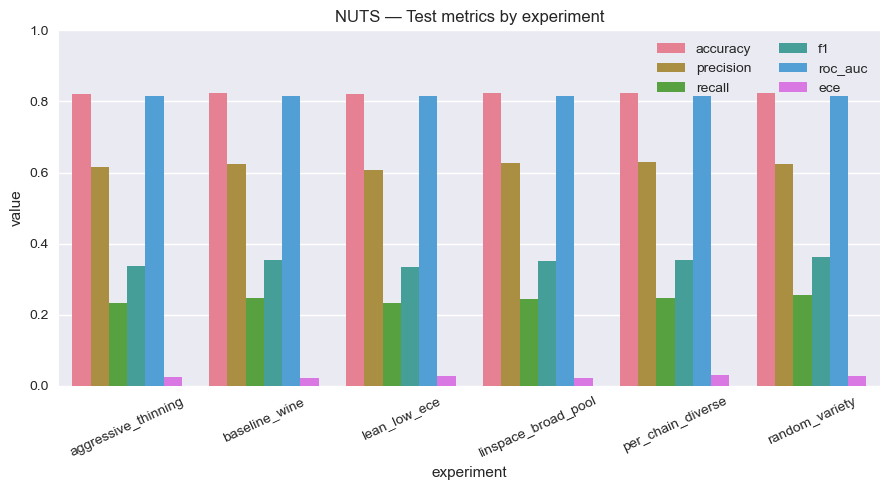

In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

try:
    import ipywidgets as widgets
    HAS_WIDGETS = True
except Exception:
    HAS_WIDGETS = False

ROOT = Path(r"c:\\Users\\roeym\\Desktop\\projects\\theses\\first_steps_ensemble")
NUTS_ROOT = ROOT / 'results' / 'ensemble_nuts'

def list_experiments(base: Path):
    return [p for p in base.iterdir() if p.is_dir() and (p / 'summary' / 'members_and_ensemble_metrics.csv').exists()]

def read_metrics(exp: Path):
    members_csv = exp / 'summary' / 'members_and_ensemble_metrics.csv'
    d = {'experiment': exp.name}
    if members_csv.exists():
        df = pd.read_csv(members_csv)
        ens = df[df['type']=='ensemble']
        if not ens.empty:
            row = ens.iloc[0]
            for k in ['accuracy_test','precision_test','recall_test','f1_test','roc_auc_test','log_loss_test','ece_test']:
                d[k.replace('_test','')] = float(row.get(k, np.nan))
    return d

exps = list_experiments(NUTS_ROOT)
records = [read_metrics(p) for p in exps]
nuts_table = pd.DataFrame(records).set_index('experiment') if records else pd.DataFrame()

if nuts_table.empty:
    print('No NUTS experiments found under', NUTS_ROOT)
else:
    display(nuts_table)
    metric_candidates = ['accuracy','precision','recall','f1','roc_auc','ece']
    metrics_avail = [m for m in metric_candidates if m in nuts_table.columns]
    if metrics_avail:
        dfp = nuts_table.reset_index().melt(id_vars='experiment', value_vars=metrics_avail, var_name='metric', value_name='value')
        plt.figure(figsize=(max(8, 1.5*len(exps)), 5))
        sns.barplot(data=dfp, x='experiment', y='value', hue='metric')
        plt.title('NUTS — Test metrics by experiment')
        plt.xticks(rotation=25)
        plt.ylim(0, 1)
        plt.legend(loc='best', ncols=2)
        plt.tight_layout(); plt.show()

    if HAS_WIDGETS and len(exps) > 0:
        options = list(nuts_table.index)
        dd = widgets.Dropdown(options=options, description='NUTS Exp:')
        out = widgets.Output()

        def render(exp_name):
            with out:
                out.clear_output()
                exp = NUTS_ROOT / exp_name
                df = pd.read_csv(exp / 'summary' / 'members_and_ensemble_metrics.csv')
                ens = df[df['type']=='ensemble']
                if not ens.empty:
                    row = ens.iloc[0]
                    metrics = ['accuracy_test','precision_test','recall_test','f1_test','roc_auc_test']
                    labels = [m.replace('_test','') for m in metrics]
                    vals = [float(row.get(m, np.nan)) for m in metrics]
                    vals = np.array(vals, dtype=float)
                    N = len(labels)
                    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist(); angles += angles[:1]
                    vals_c = vals.tolist(); vals_c += vals_c[:1]
                    fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(5,5))
                    ax.plot(angles, vals_c, linewidth=2, label=exp_name)
                    ax.fill(angles, vals_c, alpha=0.15)
                    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
                    ax.set_ylim(0, 1)
                    ax.set_title(f'{exp_name} — Ensemble radar (test)')
                    plt.show()
                    display(pd.DataFrame([vals], columns=labels, index=[exp_name]))
                else:
                    print('No ensemble row in metrics for', exp_name)
                render_experiment_member_corr(exp)

        def on_change(change):
            if change.get('name') == 'value' and change.get('new') != change.get('old'):
                render(change['new'])

        dd.observe(on_change, names='value')
        ui = widgets.VBox([dd, out])
        display(ui)
        render(options[0])
    else:
        print('ipywidgets not available or no experiments; skipping interactive section.')

# BNN ensembles — KPIs, bars, and member-correlation heatmap

,accuracy,precision,recall,f1,roc_auc,log_loss,ece
experiment,,,,,,,
bnn_baseline_posterior_400,0.674615,0.692678,0.873633,0.772703,0.739986,0.613889,0.111105
bnn_baseline_small_fast,0.681538,0.705528,0.852977,0.772277,0.726243,0.593305,0.061195
bnn_baseline_thinning_stride_5,0.703846,0.715976,0.882139,0.790419,0.762751,0.589885,0.103836


,accuracy,precision,recall,f1,roc_auc,log_loss,ece
experiment,,,,,,,
bnn_baseline_posterior_400,0.674615,0.692678,0.873633,0.772703,0.739986,0.613889,0.111105
bnn_baseline_small_fast,0.681538,0.705528,0.852977,0.772277,0.726243,0.593305,0.061195
bnn_baseline_thinning_stride_5,0.703846,0.715976,0.882139,0.790419,0.762751,0.589885,0.103836


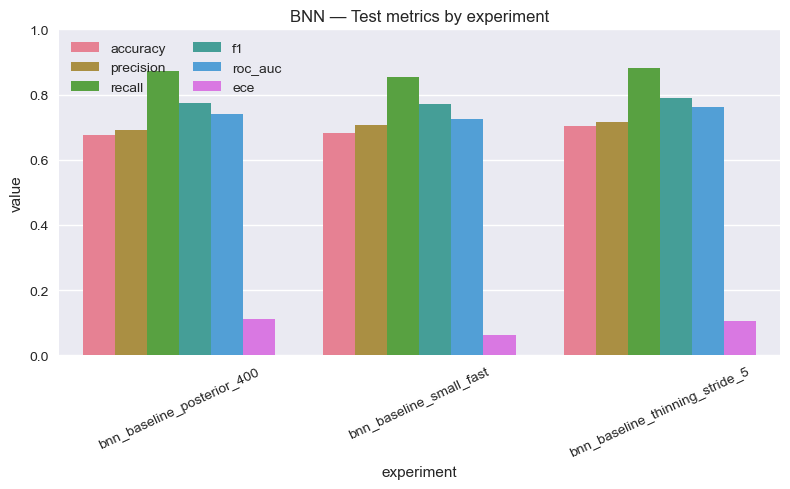

In [7]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

try:
    import ipywidgets as widgets
    HAS_WIDGETS = True
except Exception:
    HAS_WIDGETS = False

ROOT = Path(r"c:\\Users\\roeym\\Desktop\\projects\\theses\\first_steps_ensemble")
BNN_ROOT = ROOT / 'results' / 'ensemble_bnn'

def list_experiments(base: Path):
    return [p for p in base.iterdir() if p.is_dir() and (p / 'summary' / 'members_and_ensemble_metrics.csv').exists()]

def read_metrics(exp: Path):
    members_csv = exp / 'summary' / 'members_and_ensemble_metrics.csv'
    d = {'experiment': exp.name}
    if members_csv.exists():
        df = pd.read_csv(members_csv)
        ens = df[df['type']=='ensemble']
        if not ens.empty:
            row = ens.iloc[0]
            for k in ['accuracy_test','precision_test','recall_test','f1_test','roc_auc_test','log_loss_test','ece_test']:
                d[k.replace('_test','')] = float(row.get(k, np.nan))
    return d

exps = list_experiments(BNN_ROOT)
records = [read_metrics(p) for p in exps]
bnn_table = pd.DataFrame(records).set_index('experiment') if records else pd.DataFrame()

if bnn_table.empty:
    print('No BNN experiments found under', BNN_ROOT)
else:
    display(bnn_table)
    metric_candidates = ['accuracy','precision','recall','f1','roc_auc','ece']
    metrics_avail = [m for m in metric_candidates if m in bnn_table.columns]
    if metrics_avail:
        dfp = bnn_table.reset_index().melt(id_vars='experiment', value_vars=metrics_avail, var_name='metric', value_name='value')
        plt.figure(figsize=(max(8, 1.5*len(exps)), 5))
        sns.barplot(data=dfp, x='experiment', y='value', hue='metric')
        plt.title('BNN — Test metrics by experiment')
        plt.xticks(rotation=25)
        plt.ylim(0, 1)
        plt.legend(loc='best', ncols=2)
        plt.tight_layout(); plt.show()

    if HAS_WIDGETS and len(exps) > 0:
        options = list(bnn_table.index)
        dd = widgets.Dropdown(options=options, description='BNN Exp:')
        out = widgets.Output()

        def render(exp_name):
            with out:
                out.clear_output()
                exp = BNN_ROOT / exp_name
                df = pd.read_csv(exp / 'summary' / 'members_and_ensemble_metrics.csv')
                ens = df[df['type']=='ensemble']
                if not ens.empty:
                    row = ens.iloc[0]
                    metrics = ['accuracy_test','precision_test','recall_test','f1_test','roc_auc_test']
                    labels = [m.replace('_test','') for m in metrics]
                    vals = [float(row.get(m, np.nan)) for m in metrics]
                    vals = np.array(vals, dtype=float)
                    N = len(labels)
                    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist(); angles += angles[:1]
                    vals_c = vals.tolist(); vals_c += vals_c[:1]
                    fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(5,5))
                    ax.plot(angles, vals_c, linewidth=2, label=exp_name)
                    ax.fill(angles, vals_c, alpha=0.15)
                    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
                    ax.set_ylim(0, 1)
                    ax.set_title(f'{exp_name} — Ensemble radar (test)')
                    plt.show()
                    display(pd.DataFrame([vals], columns=labels, index=[exp_name]))
                else:
                    print('No ensemble row in metrics for', exp_name)
                render_experiment_member_corr(exp)

        def on_change(change):
            if change.get('name') == 'value' and change.get('new') != change.get('old'):
                render(change['new'])

        dd.observe(on_change, names='value')
        ui = widgets.VBox([dd, out])
        display(ui)
        render(options[0])
    else:
        print('ipywidgets not available or no experiments; skipping interactive section.')

Using MLP classic experiment: mlp_classic_baseline-20250925-161447


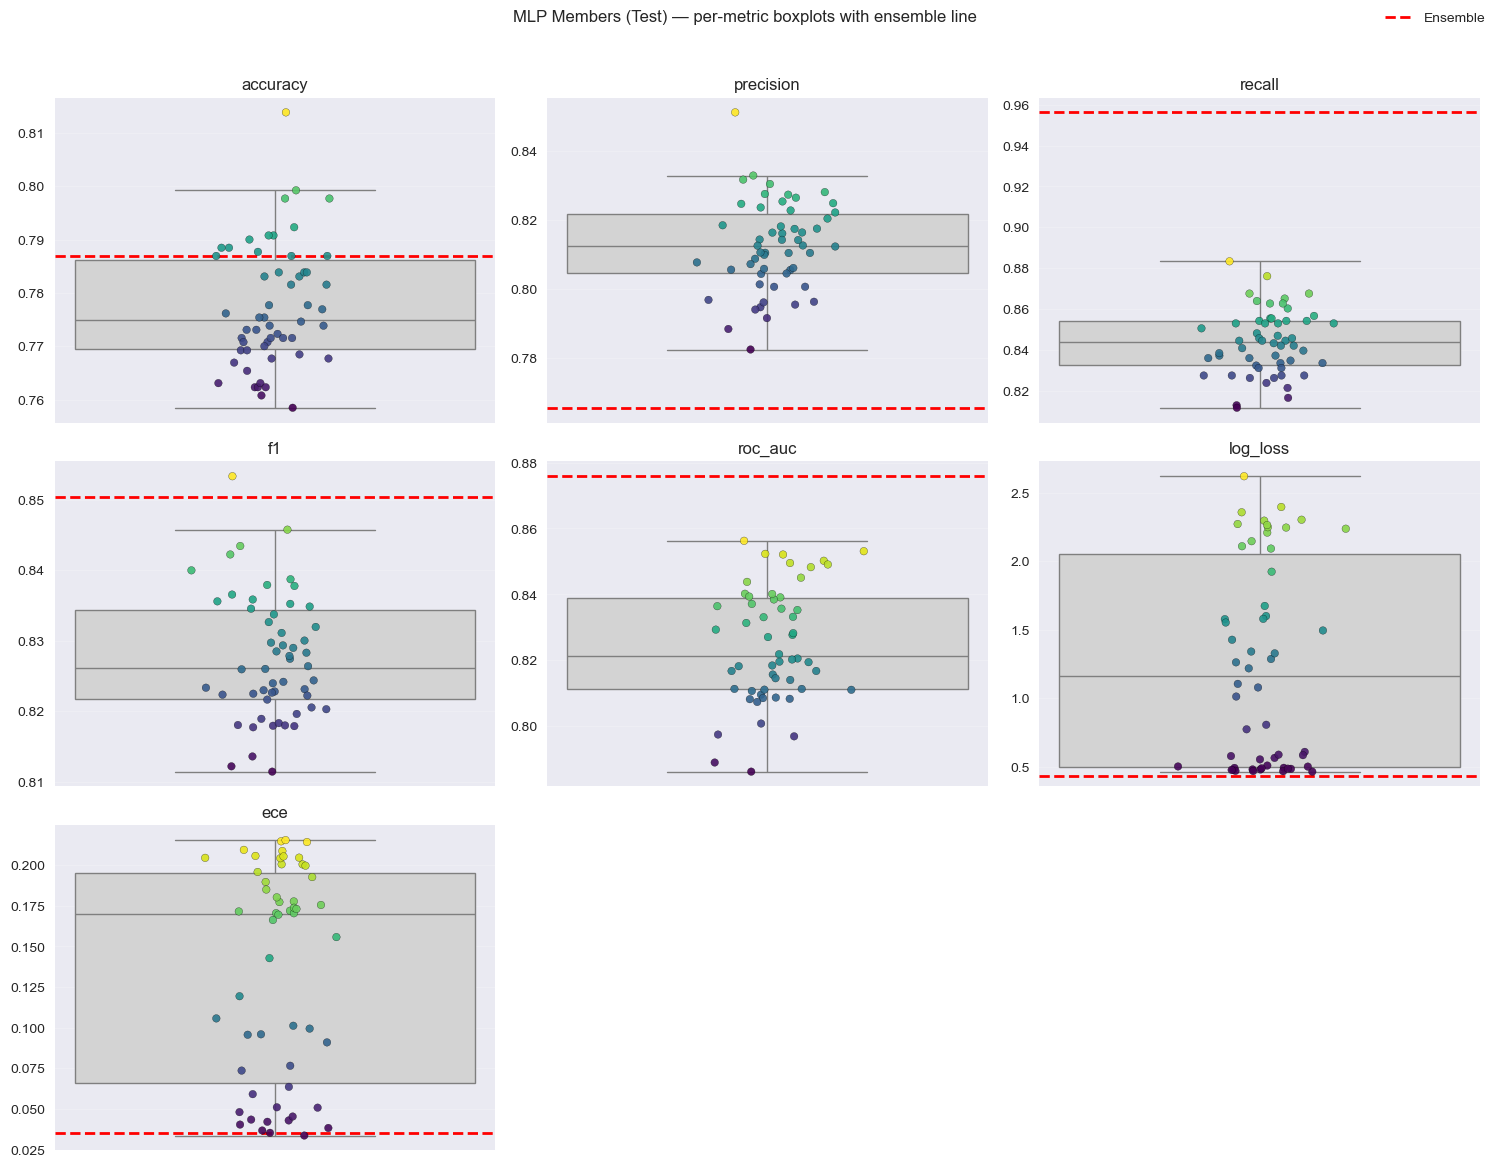

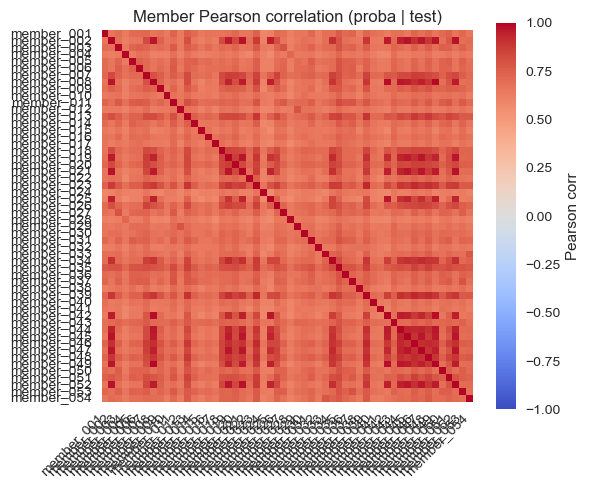

In [11]:
# Summarize MLP classic members vs ensemble (test) and render correlation heatmap
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ROOT = Path(r"c:\\Users\\roeym\\Desktop\\projects\\theses\\first_steps_ensemble")
MLP_DIR = ROOT / 'results' / 'ensemble_mlp_classic'

# Discover the latest MLP classic experiment by modified time
candidates = sorted([p for p in MLP_DIR.iterdir() if p.is_dir()], key=lambda p: p.stat().st_mtime)
if not candidates:
    print('No MLP classic experiment folders under', MLP_DIR)
else:
    mlp_exp = candidates[-1]
    print('Using MLP classic experiment:', mlp_exp.name)
    metrics_csv = mlp_exp / 'summary' / 'members_and_ensemble_metrics.csv'
    if not metrics_csv.exists():
        print('Missing metrics CSV at', metrics_csv)
    else:
        df = pd.read_csv(metrics_csv)
        members = df[df['type'] == 'member'].copy()
        ensemble = df[df['type'] == 'ensemble'].copy()

        def _find_metric_columns(df_like: pd.DataFrame, split: str):
            suffix = f'_{split}'
            prefix = f'{split}_'
            cols = [c for c in df_like.columns if c.endswith(suffix)]
            mode = 'suffix'
            if not cols:
                cols = [c for c in df_like.columns if c.startswith(prefix)]
                mode = 'prefix'
            return cols, mode

        def tidy_members(members_df: pd.DataFrame, split='test'):
            cols, mode = _find_metric_columns(members_df, split)
            if not cols:
                return pd.DataFrame()
            if mode == 'suffix':
                rename = {c: c[: -len(f'_{split}')] for c in cols}
            else:
                rename = {c: c[len(f'{split}_'):] for c in cols}

            id_candidates = ['member', 'name', 'model', 'member_id', 'member_name']
            id_col = next((c for c in id_candidates if c in members_df.columns), None)
            base = members_df.copy()
            if id_col is None:
                base = base.reset_index().rename(columns={'index': 'member_id'})
                id_col = 'member_id'
            if id_col not in base.columns:
                base['member_id'] = [f'member_{i+1:03d}' for i in range(len(base))]
                id_col = 'member_id'

            out = base[[id_col] + cols].rename(columns={id_col: 'member_id', **rename})
            return out

        def extract_ensemble_row(df_all: pd.DataFrame, split='test'):
            ens = df_all[df_all['type'] == 'ensemble']
            if ens.empty:
                return None
            cols, mode = _find_metric_columns(ens, split)
            if not cols:
                return None
            s = ens.iloc[0][cols].copy()
            if mode == 'suffix':
                s.index = [c[: -len(f'_{split}')] for c in s.index]
            else:
                s.index = [c[len(f'{split}_'):] for c in s.index]
            return s

        mem_test = tidy_members(members, split='test') if not members.empty else pd.DataFrame()
        ens_test = extract_ensemble_row(df, split='test') if not ensemble.empty else None

        if mem_test.empty or ens_test is None:
            print('No test metrics found for members or ensemble.')
        else:
            metrics = [c for c in mem_test.columns if c != 'member_id']
            n = len(metrics)
            if n == 0:
                print('No test metrics found for members.')
            else:
                ncols = 3
                nrows = int(np.ceil(n / ncols))
                fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.8*nrows), squeeze=False)

                for idx, metric in enumerate(metrics):
                    r, c = divmod(idx, ncols)
                    ax = axes[r][c]
                    vals = pd.to_numeric(mem_test[metric], errors='coerce').dropna()
                    if not vals.empty:
                        sns.boxplot(y=vals, color='lightgray', ax=ax, showfliers=False)
                        x_jit = np.random.normal(loc=0.0, scale=0.06, size=len(vals))
                        ax.scatter(x_jit, vals, c=vals, cmap='viridis', s=30, alpha=0.9, zorder=3, edgecolor='black', linewidth=0.2)
                    else:
                        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)

                    if metric in ens_test.index and pd.notna(ens_test[metric]):
                        ax.axhline(float(ens_test[metric]), color='red', linestyle='--', linewidth=2, label='Ensemble')

                    ax.set_title(metric)
                    ax.set_xlabel('')
                    ax.set_ylabel('')
                    ax.set_xticks([])
                    ax.grid(axis='y', alpha=0.2)

                total = nrows * ncols
                for j in range(n, total):
                    r, c = divmod(j, ncols)
                    axes[r][c].axis('off')

                handles, labels = [], []
                for ax in axes.flatten():
                    h, l = ax.get_legend_handles_labels()
                    if h:
                        handles, labels = h, l
                        break
                if handles:
                    fig.legend(handles, labels, loc='upper right')

                fig.suptitle('MLP Members (Test) — per-metric boxplots with ensemble line', y=1.02, fontsize=12)
                plt.tight_layout()
                plt.show()

        # Also render the unified Pearson member-correlation heatmap for this experiment
        try:
            render_experiment_member_corr(mlp_exp)
        except NameError:
            print('Correlation helper not found; run the Utility cell above first.')
